ctp7 299 IGD 0.002394760078918144


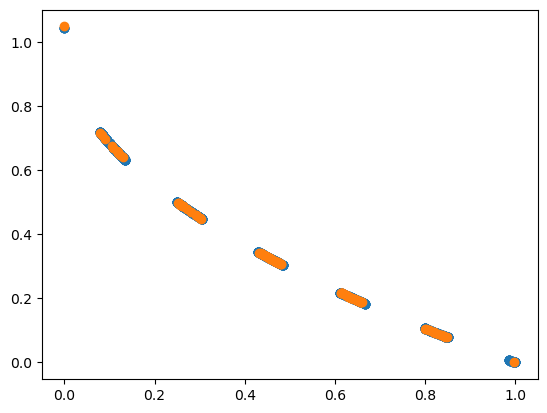

In [3]:
import numpy as np
import random
from IPython.display import clear_output
from pymoo.core.population import Population, pop_from_array_or_individual, merge
from pymoo.core.individual import Individual
from pymoo.core.evaluator import Evaluator
from pymoo.util.dominator import get_relation
from cmo.problems.factory import get_problem
from pymoo.indicators.igd import IGD
from pymoo.operators.survival.rank_and_crowding import RankAndCrowding
from matplotlib import pyplot as plt

def softmax(values, T=1.0):
    exp_values = np.exp(values / T)
    return exp_values / np.sum(exp_values)

class Qlearning:
    def __init__(self, num_states, num_actions, alpha=0.1, gamma=0.9):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = np.zeros((num_states, num_actions))

    def choose_action(self, state):
        probabilities = softmax(self.q_table[state])
        return np.random.choice(self.num_actions, p=probabilities)

    def update(self, state, action, reward, next_state):
        next_max = np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (reward + self.gamma * next_max - self.q_table[state, action])


problem_name = "ctp7"
problem = get_problem(problem_name)
pf = problem.pareto_front()
ind = IGD(pf)

num_states = 3
num_actions = 3
qlearning = Qlearning(num_states, num_actions)
BOUND_LOW, BOUND_UP = problem.bounds()

def get_offspring(pop, F, CR, index):
    num_pop = pop.shape[0]
    num_var = pop.shape[1]
    offspring = np.zeros(num_var)
    idxs = np.random.choice(num_pop, 3, replace=False)
    a, b, c = pop[idxs]
    mutant = a + F[index] * (b - c)
    jrand = np.random.randint(num_var)
    for j in range(num_var):
        if np.random.rand() < CR[index] or j == jrand:
            offspring[j] = mutant[j]
        else:
            offspring[j] = pop[index][j]
        if offspring[j] > BOUND_UP[j] or offspring[j] < BOUND_LOW[j]:
            offspring[j] = random.uniform(BOUND_LOW[j], BOUND_UP[j])
    return offspring

num_gen = 300
num_pop = 100
state = random.randint(0, num_states - 1)
F_table = np.random.random(num_pop)
CR_table = np.random.random(num_pop)
F_j = np.zeros(num_pop)
CR_j = np.zeros(num_pop)

x_max = np.array([BOUND_UP])
x_min = np.array([BOUND_LOW])
pop = np.random.rand(num_pop, problem.n_var) * (x_max - x_min) + x_min
pop = pop_from_array_or_individual(pop)
pop = Evaluator().eval(problem, pop)
for i in range(num_gen):
    offsprings = []
    for j in range(num_pop):
        F_table[j] = F_table[j] + F_j[j]
        CR_table[j] = CR_table[j] + CR_j[j]
        if F_table[j] > 1 or F_table[j] < 0:
            F_table[j] = random.random()
        if CR_table[j] > 1 or CR_table[j] < 0:
            CR_table[j] = random.random()

        offspring = Individual()
        offspring.X = get_offspring(pop.get("X"), F_table, CR_table, j)
        offspring = Evaluator().eval(problem, offspring)

        action = qlearning.choose_action(state)
        F_j[j] = [-0.1, 0.1, 0][action]
        CR_j[j] = [0.1, 0.1, 0][action]

        reward = [0, 1, -1][get_relation(offspring, pop[j])]
        next_state = [2, 0, 1][reward]
        qlearning.update(state, action, reward, next_state)
        state = next_state
        offsprings.append(offspring)

    offsprings = Population.create(*offsprings)
    pop = merge(pop, offsprings)
    pop = RankAndCrowding().do(problem, pop)[:num_pop]
    # The result found by the algorithm
    A = problem.evaluate(pop.get("X"), return_values_of=["F"])
    clear_output(wait=True)
    print(f"{problem_name}", f"{i}", "IGD", ind(A))
    plt.scatter(pf[:, 0], pf[:, 1], label="Pareto front")
    plt.scatter(A[:, 0], A[:, 1], label="RLMODE")
    plt.show()